# Chainer チュートリアル その２

https://qiita.com/mitmul/items/eccf4e0a84cb784ba84a
のなかから、Chainarでのトレーニングループの書き方を練習してみる。



# Trainar

Trainerは学習を効率よく行うためのクラスである。これを使うと学習ループを陽に書く必要がなくなるだけでなく、データ転送、可視化やログの保存などを自動で行ってくれる。

Trainerクラスを使って、学習に必要なものをひとまとめする。Trainerと、それが内部に持つユーティリティクラスやモデル、データセットクラスなどは、以下のような関係になっている。

`
Trainer{
  Updater:更新を管理{
    Iterator:データを取り出す{
      Dataset:データを保持する{}
    }
    Optimizer:パラメータの更新{
      Model:ロスを計算する{}
    }
  Extentions{}
}
`

まずはデータセットとモデルの準備をしよう


In [1]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.datasets import mnist
from chainer import iterators


gpu_id = 0
batchsize = 128

train, test = mnist.get_mnist()

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

class MLP(chainer.Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(n_mid_units, n_mid_units),
            l3=L.Linear(n_mid_units, n_out),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


model = MLP()
model.to_gpu(gpu_id)


次に、Traninerを作成する。

In [2]:
from chainer import optimizers
from chainer import training

max_epoch = 10

# モデルをClassifierで包んで、ロスの計算などをモデルに含める
model = L.Classifier(model)
model.to_gpu(gpu_id)  

# 最適化手法の選択
optimizer = optimizers.SGD()
optimizer.setup(model)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

Classifierは、モデルと損失関数の評価の２つをChainにまとめるためのものである。デフォルトの損失関数は`softmax_cross_entropy`であるが、変更することができる。

`StandardUpdater`は最もシンプルなUpdaterである。他に複数のGPUでアップデートを行う`ParallelUpdater`などがある。

では、Trainerオブジェクトを作る。ここでは、updaterと学習の終了条件、結果出力のディレクトリを指定する。このディレクトリには、ログファイルやepoch数と損失のグラフ（の画像）などが出力される。

In [3]:
# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'),
                           out='mnist_result')

## Extensionの追加

TrainerにExtensionを追加すると、以下のようなことを行うことができる。

- ログを自動的にファイルに保存（`LogReport`)
 - epochやiterationごとのloss, accuracyなどを自動的に集計し、Trainerのout引数で指定した出力ディレクトリにlogというファイル名で保存する。
- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
 - Reporterによって集計された値を標準出力に出力する。どの値を出力するかは、リストで与える。
- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
 - 引数のリストで指定された値の変遷をmatplotlibライブラリを使ってグラフに描画し、出力ディレクトリにfile_name引数で指定されたファイル名で画像として保存する。
- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot/snapshot_object`）
 - (`Snapshot`): Trainerのout引数で指定した出力ディレクトリにTrainerオブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存する。このExtensionでスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になる。
 - (`Snapshot_object`):Trainerごと保存した場合、中身のモデルだけ取り出すのが面倒な場合がある。その場合は、snapshot_objectを使って指定したオブジェクト（ここではClassifierで包まれたモデル）だけを保存するようにする。Classifierは第1引数に渡されたChainオブジェクトを自身のpredictorというプロパティとして保持してロスの計算を行うChainであり、Classifierはそもそもモデル以外にパラメータを持たないので、ここでは後々学習済みモデルを推論に使うことを見越してmodel.predictorを保存対象として指定している。
- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
- モデルの構造をGraphvizのdot形式で保存（`dump_graph`）
 -  指定されたVariableオブジェクトから辿れる計算グラフをGraphvizのdot形式で保存する。保存先はTrainerのout引数で指定した出力ディレクトリ。


In [4]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

学習を開始するには、Trainerオブジェクトのメソッドrunを呼ぶ。


In [5]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.44882     0.657283       0.693711              0.845134                  4.09331       
2           0.548399    0.865005       0.429099              0.887263                  7.20981       
3           0.410674    0.888093       0.359175              0.901503                  10.3734       
4           0.359717    0.899239       0.325952              0.910403                  13.6578       
5           0.330906    0.906467       0.30308               0.914161                  16.8879       
6           0.310736    0.91153        0.288454              0.919205                  20.1177       
7           0.294611    0.916078       0.274489              0.921578                  23.3947       
8           0.281072    0.919488       0.264613              0.925237                  26.5047       
9           0.269666    0.922475       0.254862              0.92771                

ちょっとしたコードを書くだけで、豪華な出力を得ることができた。

保存した、epoch毎の損失と、epoch毎の精度のグラフを見てみよう。

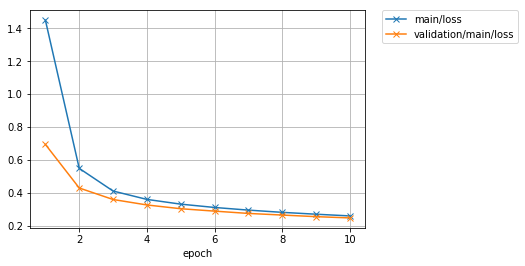

In [10]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

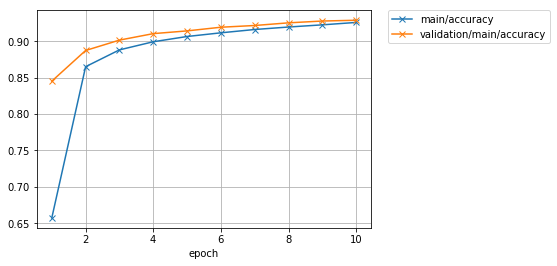

In [7]:
Image(filename='mnist_result/accuracy.png')

10 epochの時点で正の傾きがあるので、もうちょっとepochを増して精度を伸ばせそうである。

計算グラフも見てみよう。GraphVizのdotコマンドで、出力させたdotファイルから計算グラフを生成させる。

In [8]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

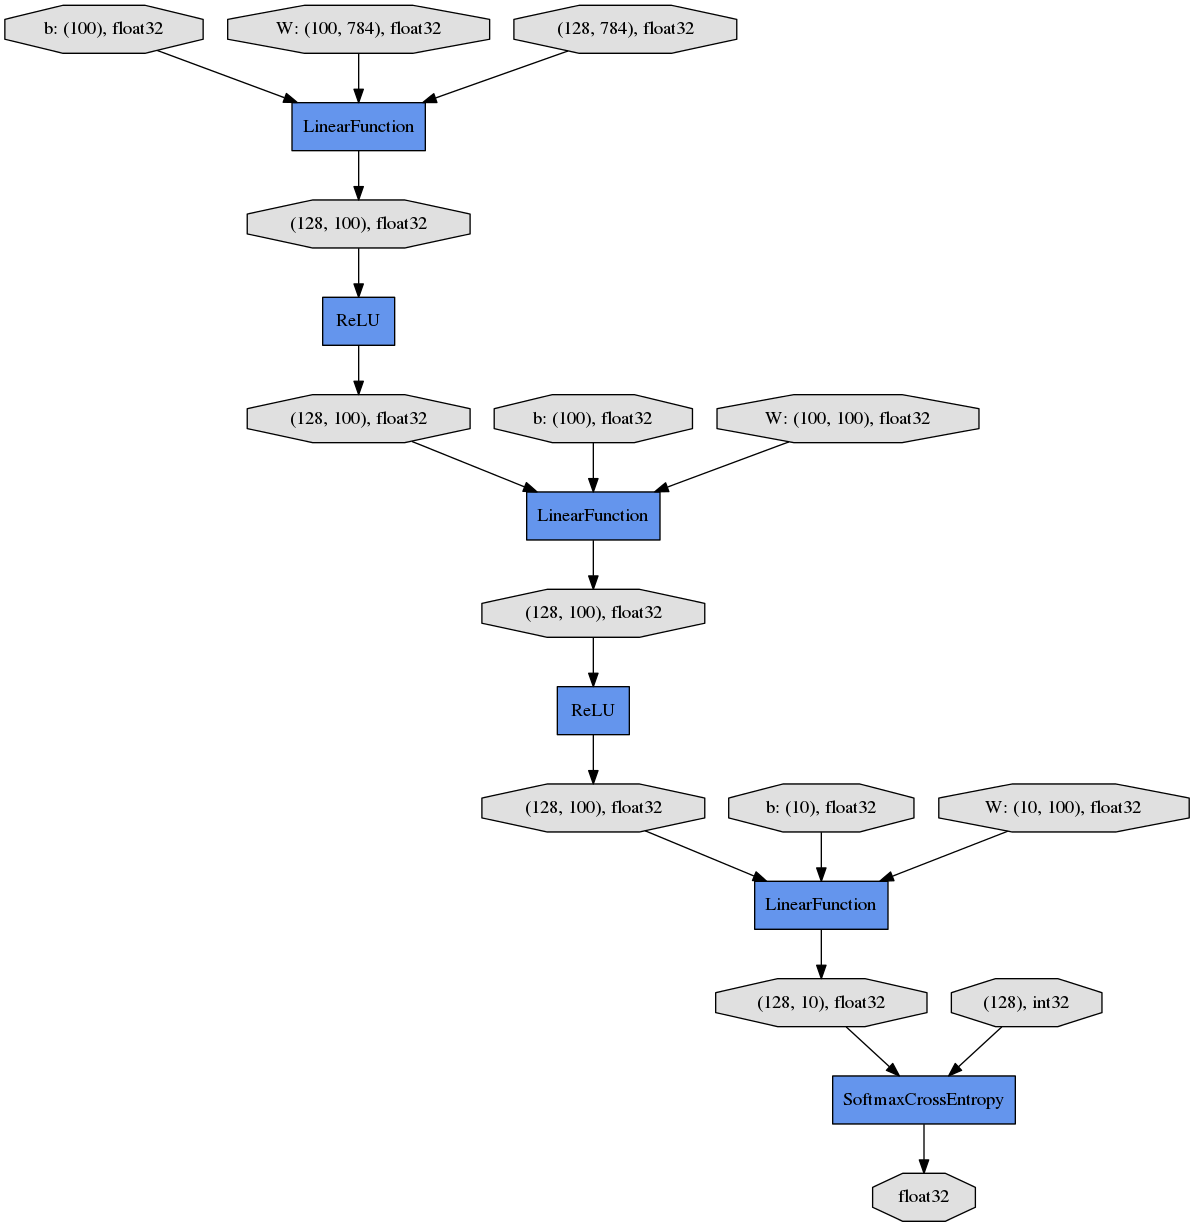

In [9]:
Image(filename='mnist_result/cg.png')

このように、学習の実験で得られるデータは、extensionを使えば簡単に保存できる。
しかし、これらが持つ意味をちゃんと勉強しておく必要はあるだろう。

## 学習済みモデルを読み出す

最後に、この実験で保存された学習モデルを読みだして、推論を行ってみよう。

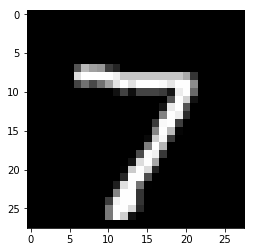

label: 7
predicted_label: 7


In [11]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)
model.to_gpu(gpu_id)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

x = to_gpu(x[None, ...])
y = model(x)
y = to_cpu(y.data)

print('predicted_label:', y.argmax(axis=1)[0])

自分で数字を書いて写真に撮り、白黒を反転させて28x28の画像に変換すると、推論ができる。

## まとめ

ここでは、Chainer流の学習ループを構築する方法を試した。
Trainerを作成して、その中にModelとデータ、optimizer、extensionをセットすれば、
自動的に訓練とログの作成を行ってくれる。
実験の時にどのようなデータが必要か、考えながらTrainerを作成しよう。
